### Imports

In [1]:
import pywt
import numpy as np
import scaleogram as scg
import matplotlib.pyplot as plt
import scipy.fftpack as fftpack
import pandas as pd
import matplotlib.image as mpimg
import os
import gc

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import keras.optimizers as opt
import tensorflow as tf
print(tf.test.is_gpu_available())

Using TensorFlow backend.


True


### Transformation definition

In [2]:
wavelet='morl'
scales = np.arange(1,128+1)
sample_len = 127
dt = 1/50
time = np.linspace(0, sample_len*dt, num=sample_len)
a= pywt.central_frequency(wavelet)/( dt * scales)

def apply_cwt(datum):
    coeff,freqs=pywt.cwt(datum,a,wavelet,dt)
    return abs(coeff)**2

### Data loading

In [3]:
dims = ["x", "y", "z"]
sigs = ["body_acc", "body_gyro", "total_acc"]
sets = ["test", "train"]

data = {}
for oset in sets:
    set_data = []
    for sig in sigs:
        sig_data = []
        for dim in dims:
            dim_data = []
            with open(f"./data/{oset}/Inertial Signals/{sig}_{dim}_{oset}.txt") as src:
                for line in src:
                    dim_data.append(np.fromstring(line, dtype=float, sep=" "))
            sig_data.append(dim_data)
        set_data.append(sig_data)
    set_label=np.fromfile(f"./data/{oset}/y_{oset}.txt", sep="\n")
    data.update({f"{oset}_data": np.asarray(set_data)})
    data.update({f"{oset}_label": set_label})
    


print("train data shape: ", data["train_data"].shape)
print("train label shape: ", data["train_label"].shape)
print("test data shape: ", data["test_data"].shape)
print("test label shape: ", data["test_label"].shape)
print("test label range: ", min(data["test_label"]), max(data["test_label"]))
print("Signal shape: ", data["train_data"][0][0].shape)

train data shape:  (3, 3, 7352, 128)
train label shape:  (7352,)
test data shape:  (3, 3, 2947, 128)
test label shape:  (2947,)
test label range:  1.0 6.0
Signal shape:  (7352, 128)


### Preprocessing

In [4]:
train_d = data["train_data"]
train_l = data["train_label"]
test_d = data["test_data"]
test_l = data["test_label"]

del data

train_d = np.asarray([sig for sigarr in train_d for sig in sigarr])
test_d = np.asarray([sig for sigarr in test_d for sig in sigarr])

train_input = []
test_input = []

for sig in range(9):
    train_input.append(np.array([apply_cwt(sample) for sample in train_d[sig]]))
    
for sig in range(9):
    test_input.append(np.array([apply_cwt(sample) for sample in test_d[sig]]))

del train_d, test_d
train_input = np.asarray(train_input).transpose(1,0,2,3)
test_input = np.asarray(test_input).transpose(1,0,2,3)
#train_input = train_input.reshape(train_input.shape+(1,))
#test_input = test_input.reshape(test_input.shape+(1,))
train_label = to_categorical(train_l-1, num_classes=6)
test_label = to_categorical(test_l-1, num_classes=6)
del train_l, test_l

### Creating the model

In [5]:
model = Sequential([
    Conv2D(128, (5,5), activation="relu", input_shape=(9,128,128), data_format="channels_first")
    , MaxPooling2D(data_format="channels_first")
    , Conv2D(64, (5,5), activation="relu", data_format="channels_first")
    , MaxPooling2D(data_format="channels_first")
    , Flatten()
    , Dense(20, activation="relu")
    , Dense(6, activation="softmax")
]
)
model.summary()
model.compile(optimizer=opt.Adam(lr=0.003), loss="categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 124)     28928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 62, 62)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 58, 58)        204864    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 29, 29)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1076500   
________________________________________________

### Training the model

In [7]:
train_output = model.fit(train_input, train_label
                         , batch_size=16
                         , epochs=15
                         , validation_data=(test_input, test_label)
)

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 20s 3ms/step - loss: 0.2153 - accuracy: 0.9251 - val_loss: 0.3241 - val_accuracy: 0.9169
Epoch 2/15
7352/7352 [==============================] - 20s 3ms/step - loss: 0.1492 - accuracy: 0.9361 - val_loss: 0.3084 - val_accuracy: 0.8863
Epoch 3/15
7352/7352 [==============================] - 20s 3ms/step - loss: 0.1323 - accuracy: 0.9433 - val_loss: 0.3146 - val_accuracy: 0.9220
Epoch 4/15
7352/7352 [==============================] - 19s 3ms/step - loss: 0.1519 - accuracy: 0.9402 - val_loss: 0.2435 - val_accuracy: 0.9196
Epoch 5/15
7352/7352 [==============================] - 19s 3ms/step - loss: 0.1223 - accuracy: 0.9513 - val_loss: 0.2154 - val_accuracy: 0.9382
Epoch 6/15
7352/7352 [==============================] - 19s 3ms/step - loss: 0.1663 - accuracy: 0.9421 - val_loss: 0.2488 - val_accuracy: 0.9348
Epoch 7/15
7352/7352 [==============================] - 19s 3ms/step - loss: 0.115

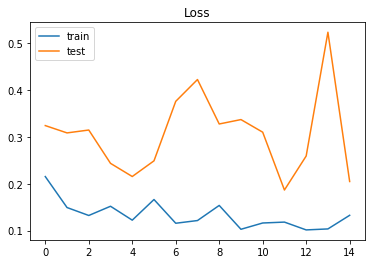

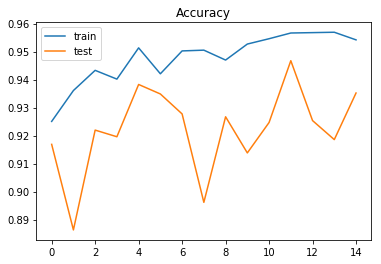

In [15]:
plt.title("Loss")
plt.plot(train_output.history["loss"], label="train")
plt.plot(train_output.history["val_loss"], label="test")
plt.legend()
plt.show()
plt.title("Accuracy")
plt.plot(train_output.history["accuracy"], label="train")
plt.plot(train_output.history["val_accuracy"], label="test")
plt.legend()
plt.show()

### Comment

I basically got very lucky and started off a very high accuracy. This means my model started out well adapted and could be called a natural genius. The problem is it quickly overlearned because of that